In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

def to_np(tensor):
    return tensor.detach().cpu().numpy()

/home/xingyu/anaconda3/envs/cpal/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping
Skipping
Skipping
Skipping


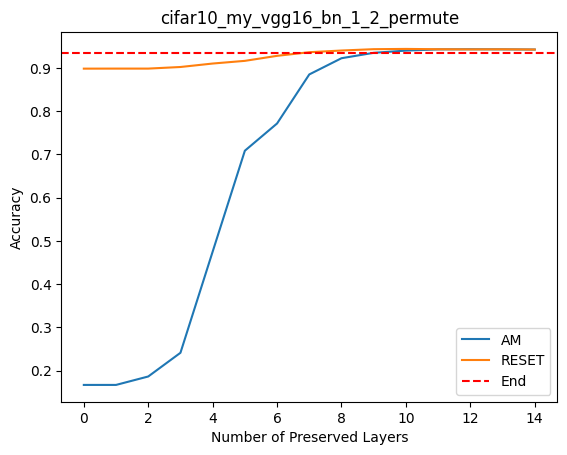

Skipping
Skipping
Skipping
Skipping


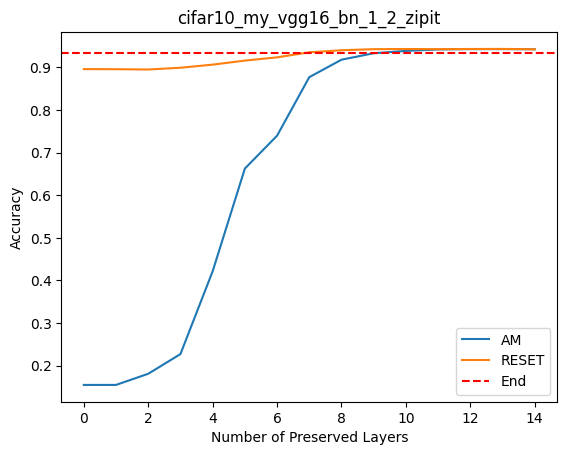

Skipping
Skipping
Skipping
Skipping


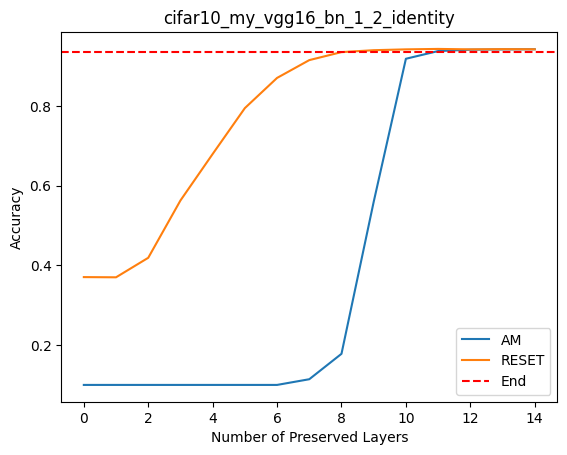

In [2]:
save_path = 'pfm_results/cifar/cifar10_my_vgg16_bn_1_2_results.pth'
save_dir = 'pfm_results/cifar_plots/'
res_dict = torch.load(save_path)
data_model = save_path.split('/')[-1].split('.')[0]

key_label_map = {'bias_corr': 'Bias Corr.', 'rescale': 'RESCALE', 'repair': 'REPAIR', 'merger': 'AM', 'reset': 'RESET', 'zero_bias': 'Zero Bias'}
merging_fn_s = ['match_tensors_permute', 'match_tensors_zipit', 'match_tensors_identity']
for i, merging_fn in enumerate(merging_fn_s):
    if merging_fn not in res_dict:
        del merging_fn_s[i]

base_0 = res_dict['base_0']
base_1 = res_dict['base_1']
end_acc = (base_0['acc'] + base_1['acc']) / 2
ensemble_acc = res_dict['ensemble']['acc']

for merging_fn in merging_fn_s:

    merging_fn_res = res_dict[merging_fn]
    metric_key = 'acc'
    merging_fn_name = merging_fn.split('_')[-1]
    title = data_model.replace('results', merging_fn_name)
    for method_key in merging_fn_res.keys():
        method_res = merging_fn_res[method_key]
        metric = method_res[metric_key]
        if len(metric) == 0:
            print('Skipping')
            continue
        acc_array = to_np(metric)
        acc_array = np.append(acc_array, ensemble_acc)
        plt.plot(acc_array, label=key_label_map[method_key])
        
    plt.ylabel('Accuracy' if metric_key == 'acc' else 'Loss')
    plt.xlabel('Number of Preserved Layers')
    # plot the end accuracy
    plt.axhline(y=end_acc, color='r', linestyle='--', label='End')
    plt.legend()
    plt.title(title)

    ## save
    save_path = save_dir + title + '.pdf'
    if os.path.exists(save_dir) is False:
        os.makedirs(save_dir)
    if os.path.exists(save_path):
        print('File already exists')
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()

CPAL imagenet resnet50 plot

In [13]:
stat_dict = torch.load('resnet50_pfm_details.pt')
param_ratio = stat_dict['param_ratio']
flops_ratio = stat_dict['flops_ratio']

/tmp/ipykernel_1826214/4095107484.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat_dict = torch.load('resnet50_pfm_details.pt')


In [63]:
flops_ratio_x_s = []
for th in [1.2, 1.6, 1.8]:
    last_index = np.where(flops_ratio[flops_ratio < th])[0][-1]
    flops_ratio_x_s.append(last_index+1)

flops_ratio_label_s = ['1.2x FLOPs', '1.6x FLOPs', '1.8x FLOPs']

In [64]:
param_ratio_x_s = []
for th in [1.2, 1.4, 1.8]:
    last_index = np.where(param_ratio[param_ratio < th])[0][-1]
    param_ratio_x_s.append(last_index+1)

param_ratio_label_s = ['1.2x Params', '1.4x Params', '1.8x Params']

/tmp/ipykernel_1826214/44164375.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(save_path)


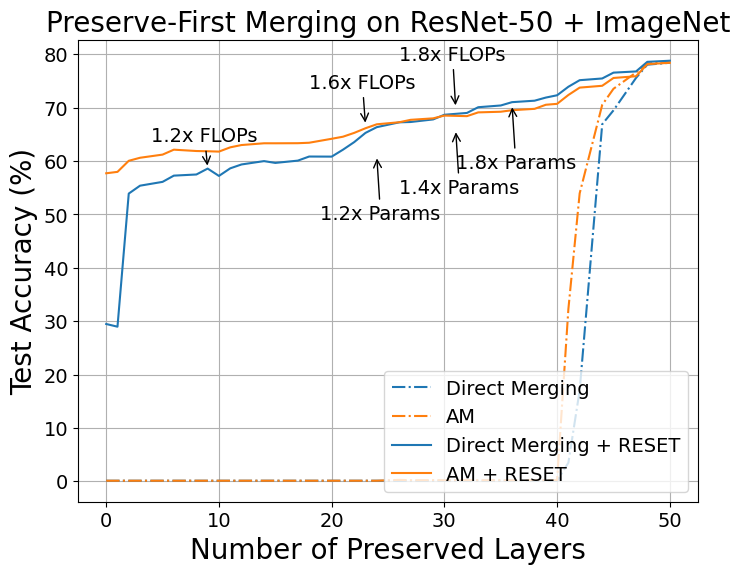

In [ ]:
save_path = 'pfm_results/imagenet/imagenet_resnet50_1_2_results.pth'
save_dir = 'pfm_results/imagenet_plots/'
res_dict = torch.load(save_path)

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

base_0 = res_dict['base_0']
base_1 = res_dict['base_1']
end_acc = (base_0['acc'] + base_1['acc']) / 2

plt.plot(stat_dict['preserverd_num'], res_dict['match_tensors_identity']['merger']['acc']*100, label='Direct Merging', color='tab:blue', linestyle='-.')
plt.plot(stat_dict['preserverd_num'], res_dict['match_tensors_permute']['merger']['acc']*100, label='AM', color='tab:orange', linestyle='-.')
plt.plot(stat_dict['preserverd_num'], res_dict['match_tensors_identity']['reset']['acc']*100, label='Direct Merging + RESET', color='tab:blue',)
plt.plot(stat_dict['preserverd_num'], res_dict['match_tensors_permute']['reset']['acc']*100, label='AM + RESET', color='tab:orange')

# write the flops_ratio and param_ratio; use a arrow to point to the direct merging + reset
for i, x in enumerate(flops_ratio_x_s):
    plt.annotate(flops_ratio_label_s[i], (x, res_dict['match_tensors_identity']['reset']['acc'][x]*100-(i*2)), xytext=(x-5, res_dict['match_tensors_identity']['reset']['acc'][x]*100+5), arrowprops=dict(facecolor='black', arrowstyle='->'))
    
for i, x in enumerate(param_ratio_x_s):
    plt.annotate(param_ratio_label_s[i], (x, res_dict['match_tensors_identity']['reset']['acc'][x]*100-8), xytext=(x-5, res_dict['match_tensors_identity']['reset']['acc'][x]*100-20), arrowprops=dict(facecolor='black', arrowstyle='->'))

# plot the end accuracy
# plt.axhline(y=end_acc*100, color='r', linestyle='--', label='End')
plt.xlabel('Number of Preserved Layers', fontsize=20)
plt.ylabel('Test Accuracy (%)', fontsize=20)
plt.title('Preserve-First Merging on ResNet-50 + ImageNet', fontsize=20)
plt.grid(True)
plt.legend(loc='lower right')

## Calculate mean and std

In [8]:
import torch
from copy import deepcopy

pair_s = ['1_2', '2_3', '1_3']
save_path_template = 'pfm_results/cifar/cifar10_my_vgg16_{}_results.pth'
save_path_s = [save_path_template.format(pair) for pair in pair_s]
res_dict_s = [torch.load(save_path) for save_path in save_path_s]

In [9]:
def calculate_multiple_dicts_mean_std(dicts):
    if not dicts:
        return {}
    first_item = dicts[0]
    if isinstance(first_item, dict):
        return {
            key: calculate_multiple_dicts_mean_std([d[key] for d in dicts])
            for key in first_item
        }
    elif isinstance(first_item, torch.Tensor):
        if first_item.numel() > 0:
            all_tensors = torch.stack([d for d in dicts if d.numel() > 0])
            return {
                'mean': torch.mean(all_tensors, dim=0).tolist(),
                'std': torch.std(all_tensors, dim=0).tolist()
            }
        else:
            return {'mean': None, 'std': None} 
    elif isinstance(first_item, (float, int)):
        all_values = torch.tensor([d for d in dicts], dtype=torch.float32)
        return {
            'mean': torch.mean(all_values).item(),
            'std': torch.std(all_values).item()
        }
    else:
        return None

In [10]:
# create a mean dict to store the mean values over all the pairs, a std dict to store the std values
summary_dict = calculate_multiple_dicts_mean_std(res_dict_s)

For models without batch normalization. 

In [11]:
print('baseline:')
print('base_0:', summary_dict['base_0']['acc']['mean']*100)
print('base_0:', summary_dict['base_0']['acc']['std']*100)
print('base_1:', summary_dict['base_1']['acc']['mean']*100)
print('base_1:', summary_dict['base_1']['acc']['std']*100)
print('ensemble:', summary_dict['ensemble']['acc']['mean']*100)
print('ensemble:', summary_dict['ensemble']['acc']['std']*100)

matching_fn = 'match_tensors_identity'

print('Direct:')
print(np.array(summary_dict[matching_fn]['merger']['acc']['mean'])[[0, 3, 6, 8, 12]].round(4)*100)
print(np.array(summary_dict[matching_fn]['merger']['acc']['std'])[[0, 3, 6, 8, 12]].round(4)*100)

matching_fn = 'match_tensors_zipit'
print('W/o Norm:')
print(np.array(summary_dict[matching_fn]['merger']['acc']['mean'])[[0, 3, 6, 8, 12]].round(4)*100)
print(np.array(summary_dict[matching_fn]['merger']['acc']['std'])[[0, 3, 6, 8, 12]].round(4)*100)
print('Repair:')
print(np.array(summary_dict[matching_fn]['repair']['acc']['mean'])[[0, 3, 6, 8, 12]].round(4)*100)
print(np.array(summary_dict[matching_fn]['repair']['acc']['std'])[[0, 3, 6, 8, 12]].round(4)*100)
print('Rescale:')
print(np.array(summary_dict[matching_fn]['rescale']['acc']['mean'])[[0, 3, 6, 8, 12]].round(4)*100)
print(np.array(summary_dict[matching_fn]['rescale']['acc']['std'])[[0, 3, 6, 8, 12]].round(4)*100)
print('Bias Cal.:')
print(np.array(summary_dict[matching_fn]['bias_corr']['acc']['mean'])[[0, 3, 6, 8, 12]].round(4)*100)
print(np.array(summary_dict[matching_fn]['bias_corr']['acc']['std'])[[0, 3, 6, 8, 12]].round(4)*100)

baseline:
base_0: 91.8833315372467
base_0: 0.023094401694834232
base_1: 91.66999459266663
base_1: 0.207846169359982
ensemble: 92.93333888053894
ensemble: 0.2926303306594491
Direct:
[10.   10.03 10.92 26.35 92.88]
[0.   0.05 0.38 6.54 0.19]
W/o Norm:
[42.62 59.73 85.3  91.01 92.89]
[3.04 3.28 0.78 0.27 0.25]
Repair:
[67.93 69.89 80.36 89.04 92.88]
[5.03 7.06 4.46 1.34 0.19]
Rescale:
[77.11 84.83 90.24 92.17 92.83]
[3.53 0.57 0.33 0.18 0.21]
Bias Cal.:
[83.24 85.78 90.2  92.04 92.74]
[0.13 0.62 0.27 0.24 0.16]


For models with batch normalization

In [7]:
print('baseline:')
print('base_0:', summary_dict['base_0']['acc']['mean']*100)
print('base_0:', summary_dict['base_0']['acc']['std']*100)
print('base_1:', summary_dict['base_1']['acc']['mean']*100)
print('base_1:', summary_dict['base_1']['acc']['std']*100)
print('ensemble:', summary_dict['ensemble']['acc']['mean']*100)
print('ensemble:', summary_dict['ensemble']['acc']['std']*100)

matching_fn = 'match_tensors_identity'
print('Number of total layers:', len(summary_dict[matching_fn]['merger']['acc']['mean']))

layer_idx_s = [0, 3, 6, 10, 12]

print('Direct:')
print(np.array(summary_dict[matching_fn]['merger']['acc']['mean'])[layer_idx_s].round(4)*100)
print(np.array(summary_dict[matching_fn]['merger']['acc']['std'])[layer_idx_s].round(4)*100)

matching_fn = 'match_tensors_permute'
print('W/o Norm:')
print(np.array(summary_dict[matching_fn]['merger']['acc']['mean'])[layer_idx_s].round(4)*100)
print(np.array(summary_dict[matching_fn]['merger']['acc']['std'])[layer_idx_s].round(4)*100)
print("reset:")
print(np.array(summary_dict[matching_fn]['reset']['acc']['mean'])[layer_idx_s].round(4)*100)
print(np.array(summary_dict[matching_fn]['reset']['acc']['std'])[layer_idx_s].round(4)*100)


matching_fn = 'match_tensors_zipit'
print('W/o Norm:')
print(np.array(summary_dict[matching_fn]['merger']['acc']['mean'])[layer_idx_s].round(4)*100)
print(np.array(summary_dict[matching_fn]['merger']['acc']['std'])[layer_idx_s].round(4)*100)
print("reset:")
print(np.array(summary_dict[matching_fn]['reset']['acc']['mean'])[layer_idx_s].round(4)*100)
print(np.array(summary_dict[matching_fn]['reset']['acc']['std'])[layer_idx_s].round(4)*100)

baseline:
base_0: 93.47999691963196
base_0: 0.034639882505871356
base_1: 93.40667128562927
base_1: 0.09814862860366702
ensemble: 94.37333941459656
ensemble: 0.09608798427507281
Number of total layers: 14
Direct:
[10.   10.   10.   92.4  94.26]
[0.  0.  0.  0.5 0.1]
W/o Norm:
[18.71 27.08 76.07 94.14 94.36]
[1.74 2.55 1.05 0.13 0.03]
reset:
[89.88 90.44 92.86 94.43 94.36]
[0.12 0.22 0.06 0.02 0.06]
W/o Norm:
[16.01 23.95 73.96 94.11 94.32]
[1.58 2.93 1.35 0.2  0.06]
reset:
[89.6  90.22 92.58 94.38 94.35]
[0.18 0.29 0.29 0.05 0.05]
